# Lab - PCR and PLS Regression

# 6.7.1 PCR: principal components regression.

In [1]:
# Examples: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
# Github: https://github.com/qx0731/ISL_python/blob/master/Chapter_6_sec_6.5_6.7.ipynb

In [2]:
import numpy as np
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd
import sklearn.linear_model as lm
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib.pyplot as plt
import pylab
from sklearn import metrics
import math
import imp
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.cross_validation import train_test_split

In [4]:
# We have to load the hitters data and ensure that the missing data have been removed:
HitterData = pd.read_csv('Dataset\Hitters.csv', na_values='?', usecols=range(0,21), header=0, parse_dates=True).dropna()

HitterData.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [5]:
HitterData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


In [6]:
dummies = pd.get_dummies(HitterData[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6 KB
   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


In [7]:
# Setting the X and Y variables:

#Response variable:
y = HitterData.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = HitterData.drop(['Unnamed: 0','Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


Here let us do PCA on the input dataset. Since the units of the variables are different the variables must be scaled

In [8]:
pca = PCA()
pca_fit = pca.fit_transform(scale(X))

#print(pca_fit)

C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


The number of PC's must be chosen. Cross validation is used for this purpose. The MSE is being computed for validation set at different number of PC's and we choose the one with the lowest validation MSE: we see this as the optimal number for PCA dimension reduction.

In [9]:
# A PCR function definition:
def pcr(X,y,pc):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    # Define the PCA object
    pca = PCA()

    # Preprocessing (1): first derivative
    X_pca = pca.fit_transform(scale(X))[:,:pc]

    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Fit
    regr.fit(X_pca, y)

    # Calibration
    y_train = regr.predict(X_pca)

    # Cross-validation
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    # Calculate scores for training and cross-validation
    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for training and cross validation
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)

C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_lau

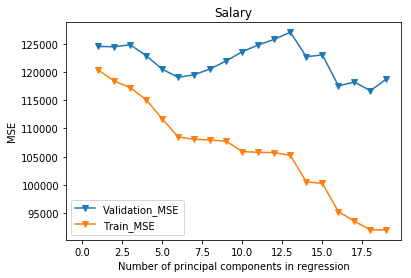

In [10]:
# We now uses the above function on the data set and plots the number of princippal components in regression opposite MSE.
mse_train = []
mse_cv = []

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    results =  pcr(X,y,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# Plot results    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)
plt.legend()
plt.show()

In [11]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

pca2 = PCA()
# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
X_reduced_test = pca2.transform(scale(X_test))[:,:6]
# Train regression model on training data 
regr = linear_model.LinearRegression()
regr.fit(X_reduced_train[:,:6], y_train)
# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  """
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


142098.96961801962

In [12]:
np.cumsum(pca.explained_variance_ratio_) * 100

array([ 38.31423957,  60.15531541,  70.8416746 ,  79.03419435,
        84.29027516,  88.63477938,  92.26288766,  94.96304322,
        96.28269124,  97.25541298,  97.97775424,  98.64870031,
        99.15178693,  99.4730334 ,  99.74659124,  99.89398793,
        99.96815949,  99.99375108, 100.        ])

# 6.7.2 PLS: Partial Least Squares

In [13]:
from sklearn.cross_decomposition import PLSRegression

In [14]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

# M = 2
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  """
C:\Users\ida_s\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  import sys


128368.05812796087

The test MSE is comparable to, but slightly higher than, the test MSE obtained using ridge regression, the lasso, and PCR.